# Unsupervised learning with PCA
This notebook demonstrates unsupervised exploration using Principal Component Analysis (PCA). It scales numeric features, fits PCA, shows explained variance (scree) plot, and projects data into 2D for visualization.

In [6]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
sns.set_theme()

In [7]:
# Load data and select numeric features
df = pd.read_csv('train.csv')
if 'Name' in df.columns:
    df = df.drop(columns=['Name'])

# Keep numeric columns for PCA
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'id' in numeric_cols:
    numeric_cols.remove('id')
print('numeric columns:', numeric_cols)
X_num = df[numeric_cols].copy()
display(X_num.head())

numeric columns: ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Depression']


,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
0,49.0,NaN,5.0,NaN,NaN,2.0,1.0,2.0,0
1,26.0,NaN,4.0,NaN,NaN,3.0,7.0,3.0,1
2,33.0,5.0,NaN,8.97,2.0,NaN,3.0,1.0,1
3,22.0,NaN,5.0,NaN,NaN,1.0,10.0,1.0,1
4,30.0,NaN,1.0,NaN,NaN,1.0,9.0,4.0,0


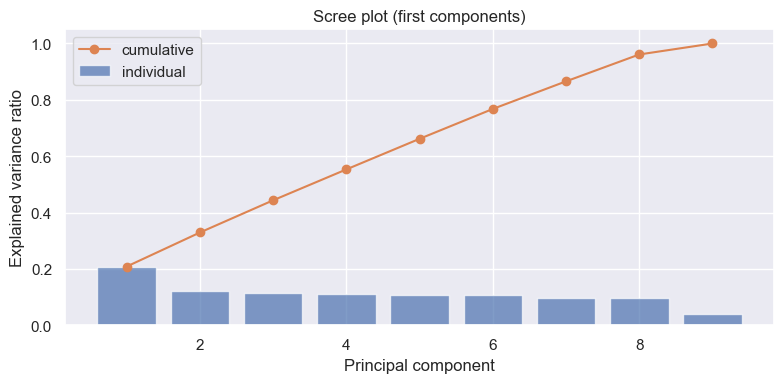

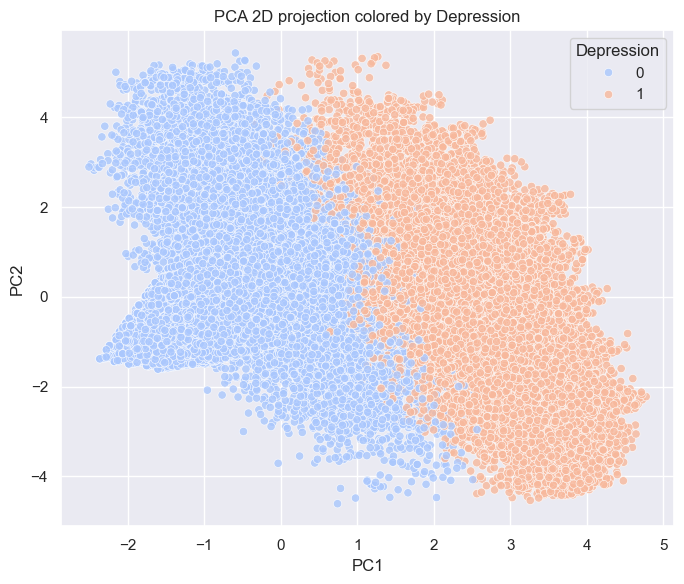

In [8]:
# Preprocess (median impute + scaling) and fit PCA
pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
X_proc = pipe.fit_transform(X_num)

# Fit PCA and show explained variance
pca = PCA(n_components=min(X_proc.shape[1], 10), random_state=42)
pca.fit(X_proc)
explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

plt.figure(figsize=(8,4))
plt.bar(range(1, len(explained)+1), explained, alpha=0.7, label='individual')
plt.plot(range(1, len(cumulative)+1), cumulative, '-o', color='C1', label='cumulative')
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.title('Scree plot (first components)')
plt.legend()
plt.tight_layout()
plt.show()

# Project to 2D for visualization
pca2 = PCA(n_components=2, random_state=42)
proj = pca2.fit_transform(X_proc)
proj_df = pd.DataFrame(proj, columns=['PC1','PC2'])
# If target present, include for coloring
if 'Depression' in df.columns:
    proj_df['Depression'] = df['Depression'].values

plt.figure(figsize=(7,6))
if 'Depression' in proj_df.columns:
    sns.scatterplot(data=proj_df, x='PC1', y='PC2', hue='Depression', palette='coolwarm', alpha=0.8)
    plt.title('PCA 2D projection colored by Depression')
else:
    plt.scatter(proj_df['PC1'], proj_df['PC2'], alpha=0.7)
    plt.title('PCA 2D projection')
plt.tight_layout()
plt.show()

,n_components,reconstruction_mse,cumulative_explained_variance
0,1,7.918092e-01,0.208191
1,2,6.709765e-01,0.329023
2,3,5.566225e-01,0.443378
3,4,4.469739e-01,0.553026
4,5,3.383377e-01,0.661662
5,6,2.323395e-01,0.767660
6,7,1.343405e-01,0.865660
7,8,3.893096e-02,0.961069
8,9,3.241589e-31,1.000000


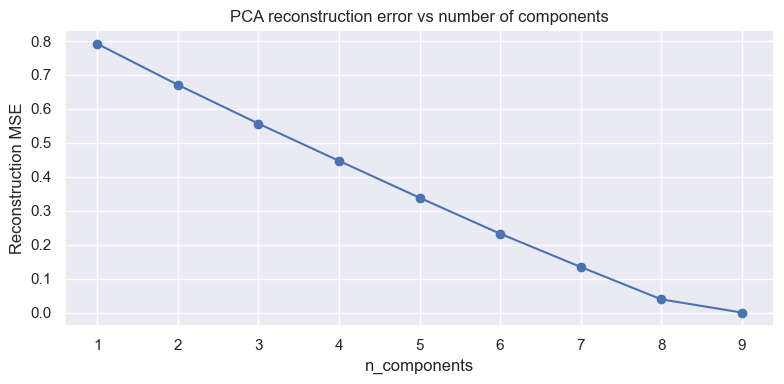

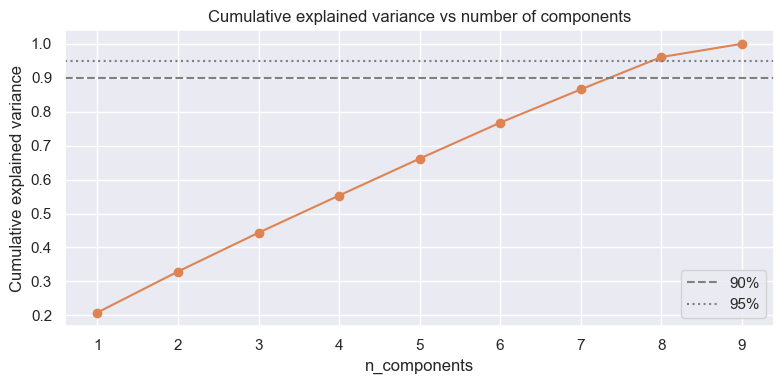

Components for 90% variance: 8
Components for 95% variance: 8
Reconstruction MSE for 2 components: 0.670977


In [9]:
# PCA metrics: reconstruction error vs n_components and components required for variance thresholds
from sklearn.metrics import mean_squared_error

max_comp = min(X_proc.shape[1], 20)
components = list(range(1, max_comp+1))
recon_errors = []
cum_explained = []
for k in components:
    p_k = PCA(n_components=k, random_state=42)
    proj_k = p_k.fit_transform(X_proc)
    recon_k = p_k.inverse_transform(proj_k)
    mse_k = mean_squared_error(X_proc, recon_k)
    recon_errors.append(mse_k)
    cum_explained.append(p_k.explained_variance_ratio_.sum())

import pandas as pd
metrics_df = pd.DataFrame({'n_components': components, 'reconstruction_mse': recon_errors, 'cumulative_explained_variance': cum_explained})
display(metrics_df.head(10))

# Plot reconstruction error
plt.figure(figsize=(8,4))
plt.plot(metrics_df['n_components'], metrics_df['reconstruction_mse'], '-o')
plt.xlabel('n_components')
plt.ylabel('Reconstruction MSE')
plt.title('PCA reconstruction error vs number of components')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot cumulative explained variance (repeat with higher resolution)
plt.figure(figsize=(8,4))
plt.plot(metrics_df['n_components'], metrics_df['cumulative_explained_variance'], '-o', color='C1')
plt.xlabel('n_components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance vs number of components')
plt.axhline(0.90, color='gray', linestyle='--', label='90%')
plt.axhline(0.95, color='gray', linestyle=':', label='95%')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

def components_for_threshold(threshold):
    for n, v in zip(metrics_df['n_components'], metrics_df['cumulative_explained_variance']):
        if v >= threshold:
            return int(n)
    return None

print('Components for 90% variance:', components_for_threshold(0.90))
print('Components for 95% variance:', components_for_threshold(0.95))

# Reconstruction error for the 2-component projection used earlier (if available)
try:
    mse_2 = mean_squared_error(X_proc, pca2.inverse_transform(proj))
    print(f'Reconstruction MSE for 2 components: {mse_2:.6f}')
except Exception as e:
    print('Could not compute 2-component reconstruction MSE:', e)

In [10]:
# Save principal components for downstream use
proj_df.to_csv('pca_2d_projection.csv', index=False)
print('Saved pca_2d_projection.csv')

Saved pca_2d_projection.csv


In [12]:
# Evaluate PCA as a feature-transform for a supervised classifier (Logistic Regression)
# This trains a simple classifier on PCA components for several k and reports CV metrics + holdout metrics so PCA performance can be compared to other models.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import numpy as np
import pandas as pd

# Ensure target exists
if 'Depression' not in df.columns:
    raise RuntimeError('Target column "Depression" not present in dataframe; run supervised models on train.csv with labels.')
y = df['Depression']
X_feat = X_num  # numeric features used for PCA; ensure previous cells have been run

# Helper to find component counts (uses metrics_df if available)
def components_for_threshold_df(threshold, metrics_df_local):
    for n, v in zip(metrics_df_local['n_components'], metrics_df_local['cumulative_explained_variance']):
        if v >= threshold:
            return int(n)
    return None

ks = [2]  # always evaluate 2 components (visualization)
# add k for 90% and 95% explained variance if available
try:
    k90 = components_for_threshold_df(0.90, metrics_df)
    k95 = components_for_threshold_df(0.95, metrics_df)
    for k in [k90, k95]:
        if k is not None and k not in ks:
            ks.append(k)
except Exception:
    # fallback: include a few common values
    ks += [5, 10]
# dedupe and sort
ks = sorted(list(dict.fromkeys(ks)))

results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for k in ks:
    print(f'\nEvaluating PCA with {k} components...')
    pipe_pca = Pipeline([('imputer_scaler', pipe), ('pca', PCA(n_components=k, random_state=42)), ('clf', LogisticRegression(max_iter=1000, random_state=42))])
    scoring = ['accuracy', 'roc_auc']
    cv_res = cross_validate(pipe_pca, X_feat, y, cv=skf, scoring=scoring, n_jobs=1)
    acc = cv_res['test_accuracy'].mean()
    roc = cv_res['test_roc_auc'].mean()
    print(f'CV accuracy: {acc:.4f}, CV ROC AUC: {roc:.4f}')
    # holdout evaluation
    X_train, X_val, y_train, y_val = train_test_split(X_feat, y, test_size=0.2, stratify=y, random_state=42)
    pipe_pca.fit(X_train, y_train)
    y_pred = pipe_pca.predict(X_val)
    y_proba = pipe_pca.predict_proba(X_val)[:,1] if hasattr(pipe_pca, 'predict_proba') else None
    acc_val = accuracy_score(y_val, y_pred)
    roc_val = roc_auc_score(y_val, y_proba) if y_proba is not None else None
    print('Holdout accuracy:', acc_val)
    if roc_val is not None:
        print('Holdout ROC AUC:', roc_val)
    print('Classification report (holdout):')
    print(classification_report(y_val, y_pred))
    results.append({'n_components': k, 'cv_accuracy': acc, 'cv_roc_auc': roc, 'val_accuracy': acc_val, 'val_roc_auc': roc_val})

results_df = pd.DataFrame(results)
print('\nSummary:')
display(results_df)


Evaluating PCA with 2 components...
CV accuracy: 0.9901, CV ROC AUC: 0.9993
Holdout accuracy: 0.9902629708599858
Holdout ROC AUC: 0.9992065964009919
Classification report (holdout):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     23027
           1       0.98      0.97      0.97      5113

    accuracy                           0.99     28140
   macro avg       0.99      0.98      0.98     28140
weighted avg       0.99      0.99      0.99     28140


Evaluating PCA with 8 components...
CV accuracy: 0.9901, CV ROC AUC: 0.9993
Holdout accuracy: 0.9902629708599858
Holdout ROC AUC: 0.9992065964009919
Classification report (holdout):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     23027
           1       0.98      0.97      0.97      5113

    accuracy                           0.99     28140
   macro avg       0.99      0.98      0.98     28140
weighted avg       0.99      0.99  

,n_components,cv_accuracy,cv_roc_auc,val_accuracy,val_roc_auc
0,2,0.990114,0.999269,0.990263,0.999207
1,8,0.996574,0.999795,0.996660,0.999780
